### 1、导入数据包

In [1]:
import gc
import os
import datetime
import numpy as np
import pandas as pd 
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

### 2、读取数据

In [2]:
%%time
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")


CPU times: user 26.8 s, sys: 1.08 s, total: 27.9 s
Wall time: 28.4 s


In [3]:
print("train_df.shape:", train_df.shape)
print("test_df.shape", test_df.shape)

train_df.shape: (200000, 202)
test_df.shape (200000, 201)


In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


### 3、数据分析

In [5]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt["Type"] = types
    
    return (np.transpose(tt))

In [6]:
%%time
# 检查训练集有没有缺失值
missing_data(train_df)

CPU times: user 4.27 s, sys: 2.42 ms, total: 4.27 s
Wall time: 4.29 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Type,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [7]:
%%time
# 检查测试集有没有缺失值
missing_data(test_df)

CPU times: user 4.23 s, sys: 2.38 ms, total: 4.24 s
Wall time: 4.27 s


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [8]:
%%time
train_df.describe()

CPU times: user 7.21 s, sys: 229 ms, total: 7.44 s
Wall time: 7.57 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [9]:
%%time 
test_df.describe()

CPU times: user 6.52 s, sys: 311 ms, total: 6.83 s
Wall time: 6.88 s


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


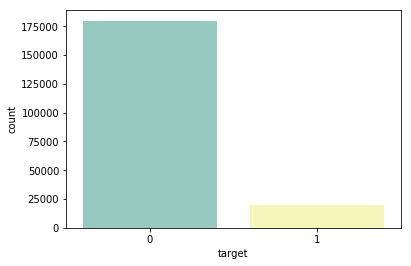

In [10]:
# 统计正负样本
sns.countplot(train_df["target"], palette="Set3")

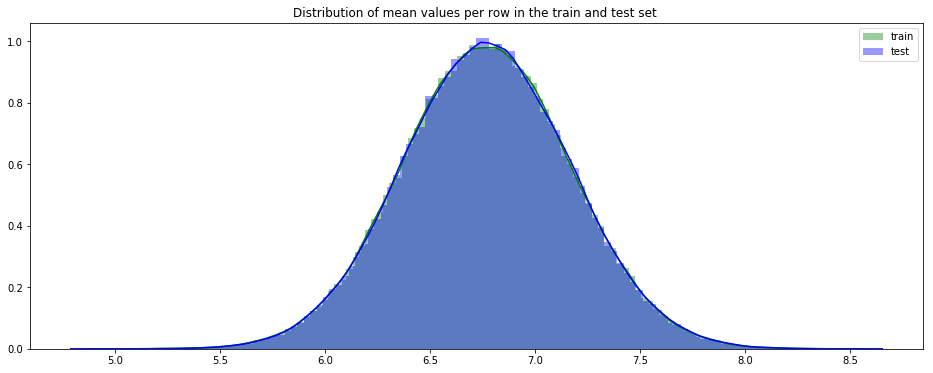

In [11]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202] 
plt.title("Distribution of mean values per row in the train and test set ")
sns.distplot(train_df[features].mean(axis=1), color="green", kde=True, bins=120, label="train")
sns.distplot(test_df[features].mean(axis=1), color="blue", kde=True, bins=120, label="test")
plt.legend()
plt.show()

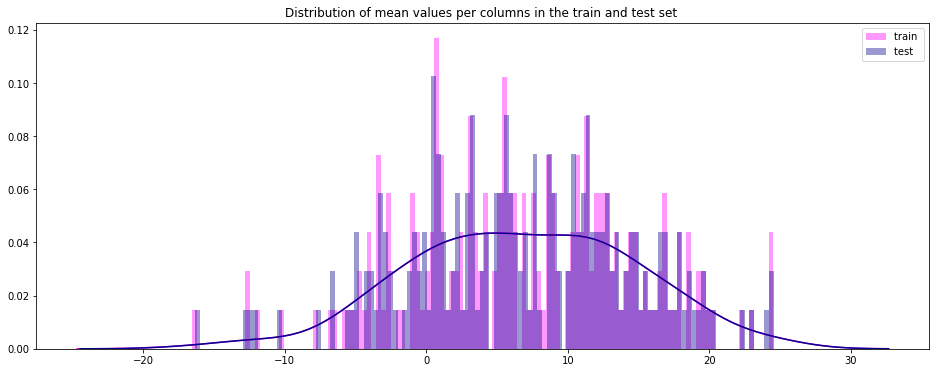

In [12]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of mean values per columns in the train and test set ")
sns.distplot(train_df[features].mean(axis=0), color="magenta", kde=True, bins=120, label="train ")
sns.distplot(test_df[features].mean(axis=0), color="darkblue", kde=True, bins=120, label="test ")
plt.legend()
plt.show()

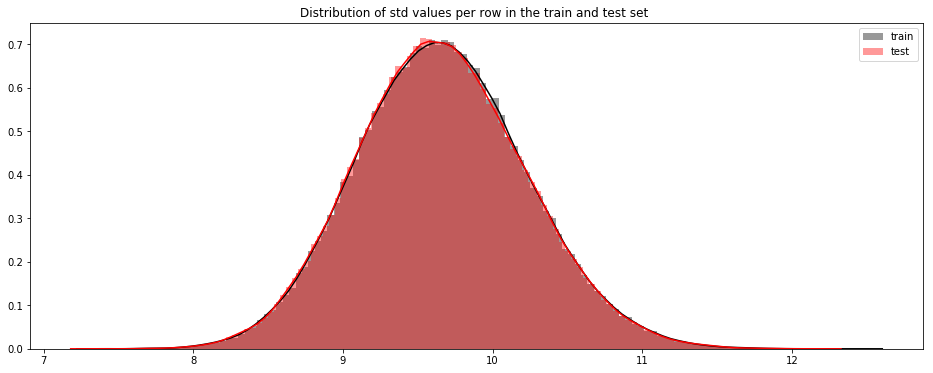

In [13]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of std values per row in the train and test set ")
sns.distplot(train_df[features].std(axis=1), color="black", kde=True, bins=120, label="train")
sns.distplot(test_df[features].std(axis=1), color="red", kde=True, bins=120, label="test")
plt.legend()
plt.show()

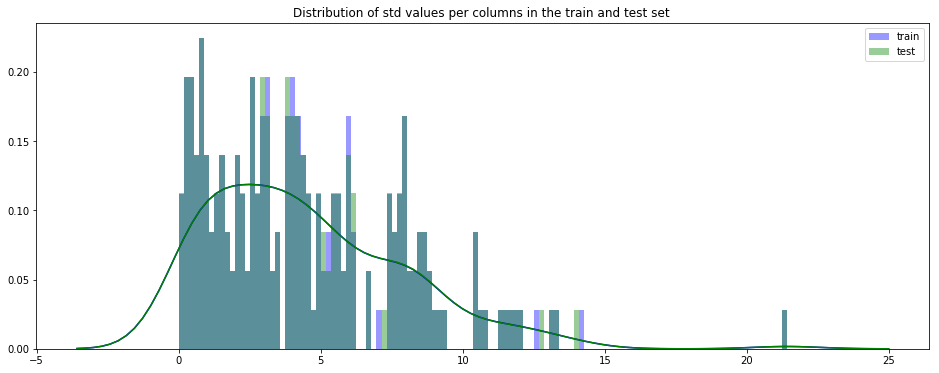

In [14]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of std values per columns in the train and test set ")
sns.distplot(train_df[features].std(axis=0), color="blue", kde=True, bins=120, label="train")
sns.distplot(test_df[features].std(axis=0), color="green", kde=True, bins=120, label="test")
plt.legend()
plt.show()

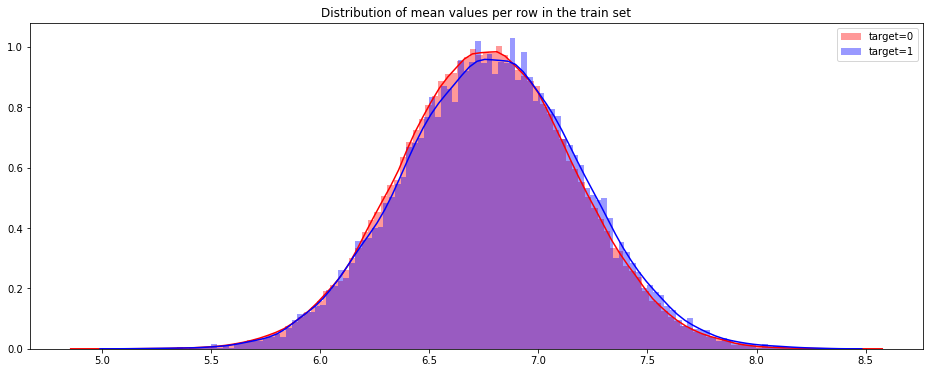

In [15]:
t0 = train_df[train_df["target"] == 0]
t1 = train_df[train_df["target"] == 1]
plt.figure(figsize=(16, 6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1), color="red", kde=True, bins=120, label="target=0")
sns.distplot(t1[features].mean(axis=1), color="blue", kde=True, bins=120, label="target=1")
plt.legend()
plt.show()

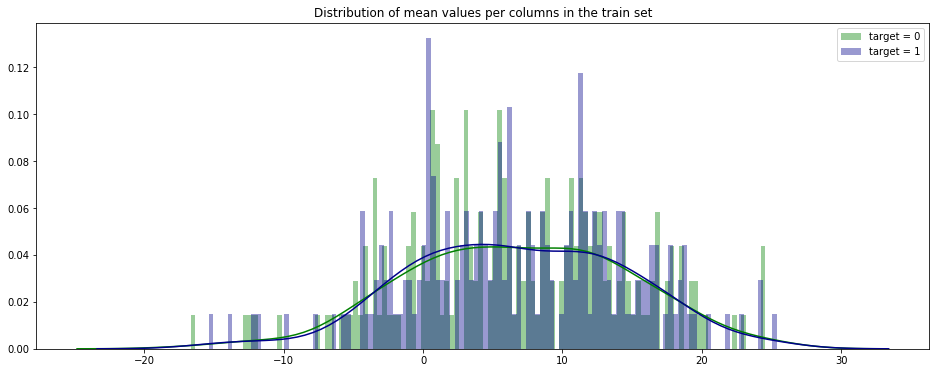

In [16]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per columns in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

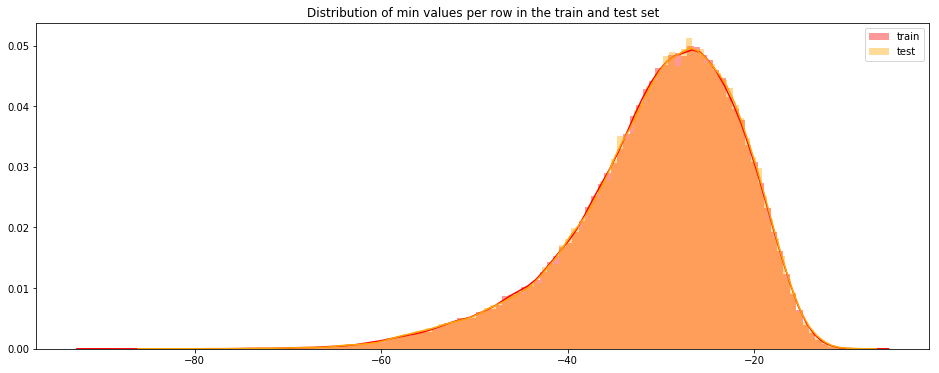

In [17]:
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1), color="red", kde=True, bins=120, label="train")
sns.distplot(test_df[features].min(axis=1), color="orange", kde=True, bins=120, label="test")
plt.legend()
plt.show()

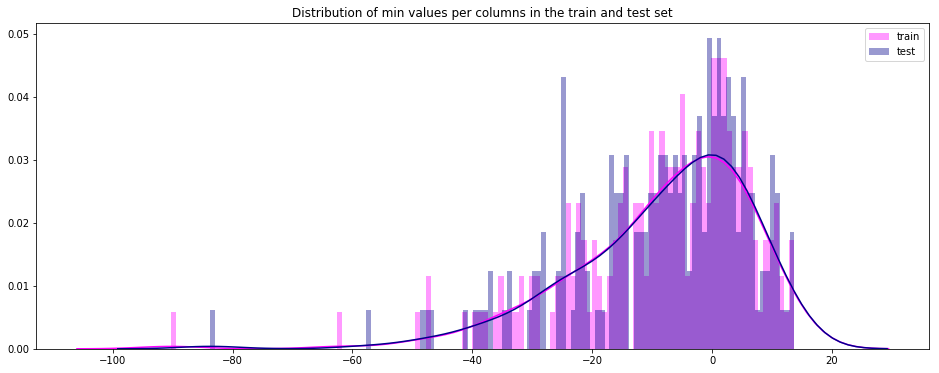

In [18]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per columns in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

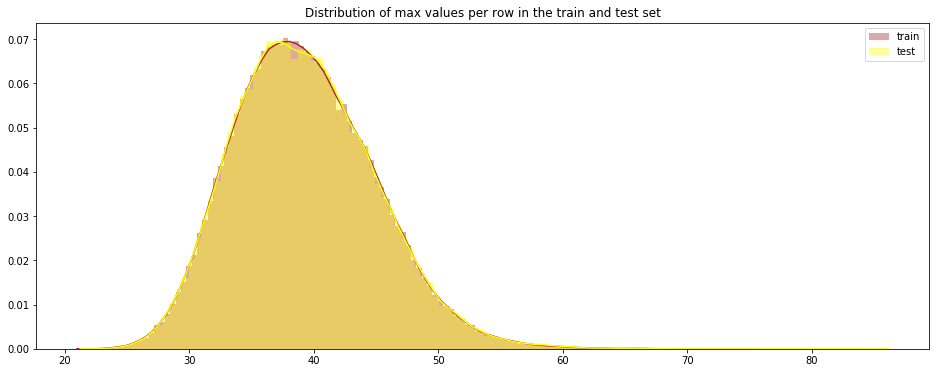

In [19]:
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1), color="brown", kde=True, bins=120, label="train")
sns.distplot(test_df[features].max(axis=1), color="yellow",kde=True, bins=120, label="test")
plt.legend()
plt.show()

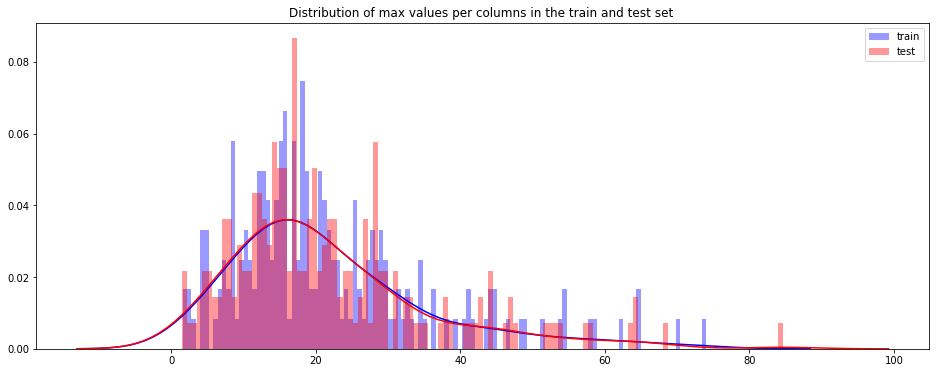

In [20]:
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per columns in the train and test set ")
sns.distplot(train_df[features].max(axis=0), color="blue", kde=True, bins=120, label="train")
sns.distplot(test_df[features].max(axis=0), color="red", kde=True, bins=120, label="test")
plt.legend()
plt.show()

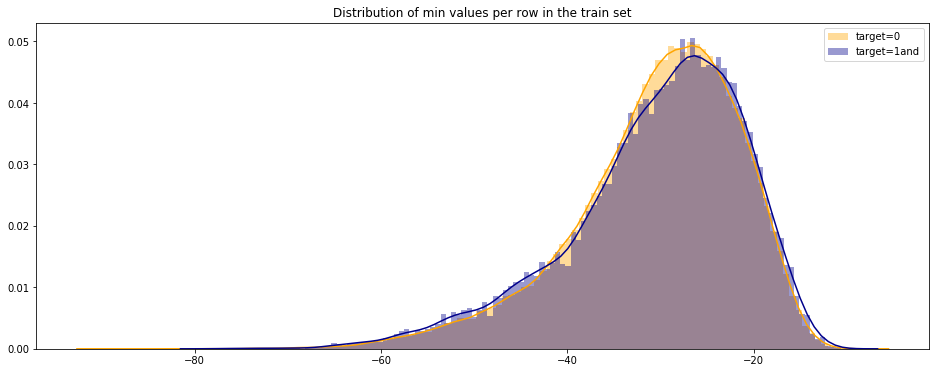

In [21]:
t0 = train_df[train_df["target"] == 0]
t1 = train_df[train_df["target"] == 1]
plt.figure(figsize=(16, 6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1), color="orange", kde=True, bins=120, label="target=0")
sns.distplot(t1[features].min(axis=1), color="darkblue", kde=True, bins=120, label="target=1and")
plt.legend()
plt.show()

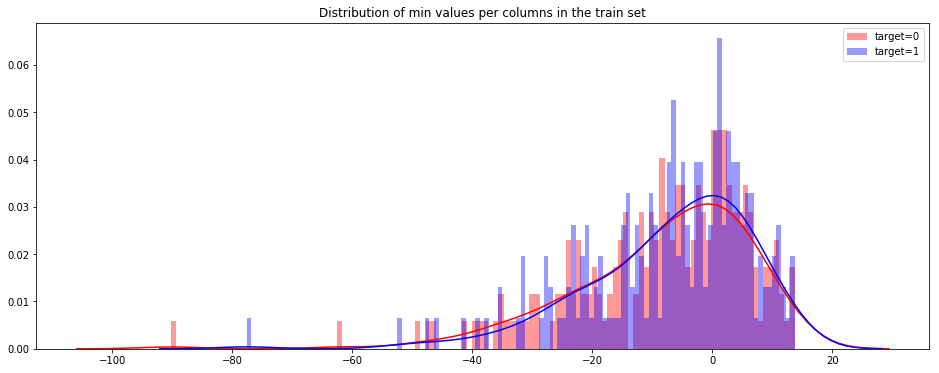

In [22]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of min values per columns in the train set")
sns.distplot(t0[features].min(axis=0), color="red", kde=True, bins=120, label="target=0")
sns.distplot(t1[features].min(axis=0), color="blue", kde=True, bins=120, label="target=1")
plt.legend()
plt.show()

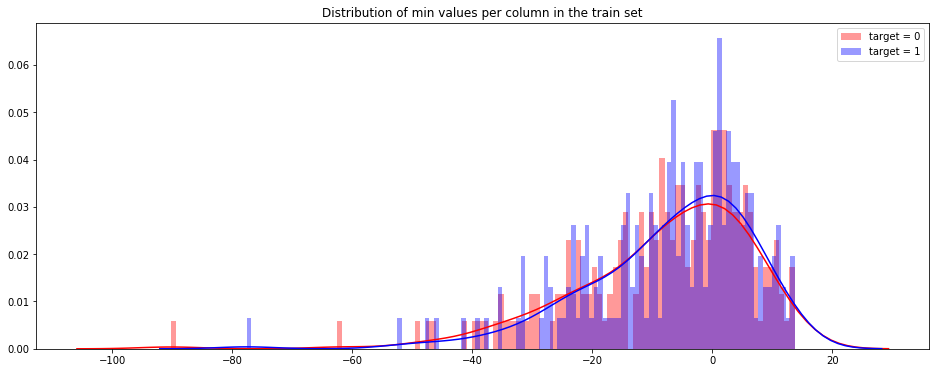

In [23]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

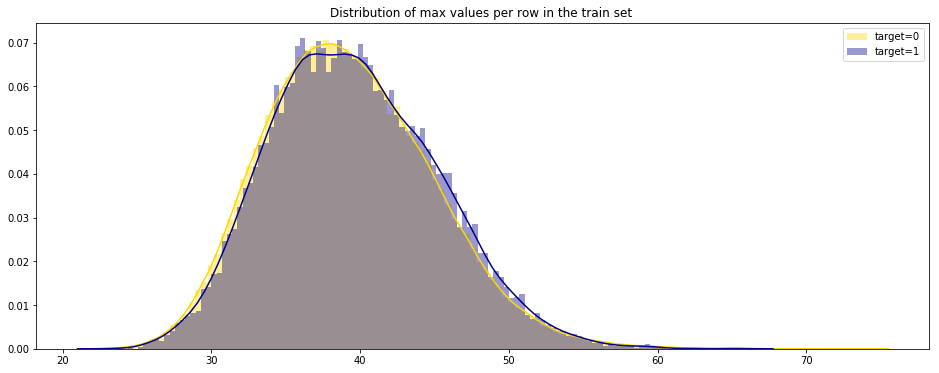

In [24]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of max values per row in the train set ")
sns.distplot(t0[features].max(axis=1), color="gold", kde=True, bins=120, label="target=0")
sns.distplot(t1[features].max(axis=1), color="darkblue", kde=True, bins=120, label="target=1")
plt.legend()
plt.show()

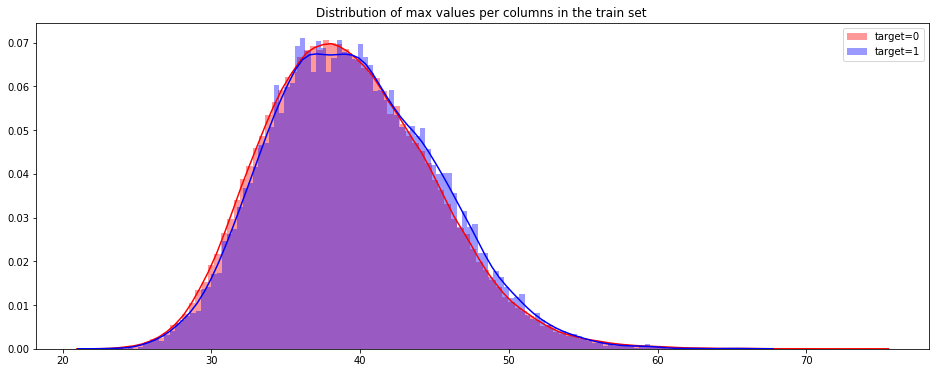

In [25]:
plt.figure(figsize=(16, 6))
plt.title("Distribution of max values per columns in the train set ")
sns.distplot(t0[features].max(axis=1), color="red", kde=True, bins=120, label="target=0")
sns.distplot(t1[features].max(axis=1), color="blue", kde=True, bins=120, label="target=1")
plt.legend()
plt.show()

### 4、特征工程

In [26]:
%%time 
idx = features = train_df.columns.values[2:202]
for df in [train_df, test_df]:
    df["sum"] = df[idx].sum(axis=1)
    df["max"] = df[idx].max(axis=1)
    df["min"] = df[idx].max(axis=1)
    df["mean"] = df[idx].mean(axis=1)
    df["std"] = df[idx].std(axis=1)
    df["skew"] = df[idx].skew(axis=1)
    df["kurt"] = df[idx].kurtosis(axis=1)
    df["med"] = df[idx].median(axis=1)

CPU times: user 30.2 s, sys: 19 s, total: 49.2 s
Wall time: 49.4 s


In [27]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_198,var_199,sum,max,min,mean,std,skew,kurt,med
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,12.7803,-1.0914,1456.3182,43.1127,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,18.3560,1.9518,1415.3636,40.5632,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,14.7222,0.3965,1240.8966,33.8820,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,17.9697,-8.9996,1288.2319,38.1015,38.1015,6.441160,9.594064,-0.480116,2.630499,6.70260
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,17.9974,-8.8104,1354.2310,41.1037,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [28]:
features = [c for c in train_df.columns if c not in ["ID_code", "target"]]
for feature in features:
    train_df["r2_" + feature] = np.round(train_df[feature], 2)
    test_df["r2_" + feature] = np.round(test_df[feature], 2)
    train_df["r1_" + feature] = np.round(train_df[feature], 1)
    test_df["r1_" + feature] = np.round(test_df[feature], 1)

In [29]:
print("train_df.shape:", train_df.shape)
print("test_df.shape:", test_df.shape)

train_df.shape: (200000, 626)
test_df.shape: (200000, 625)


### 5、建立模型

In [30]:
features = [c for c in train_df.columns if c not in ["ID_code", "target"]]
target = train_df["target"]


In [31]:
param = {"bagging_freq": 5,
         "bagging_fraction": 0.4,
         "boost_from_average": "false",
         "boost": "gbdt",
         "feature_fraction": 0.05,
         "learning_rate": 0.01,
         "max_depth": -1,
         "metric": "auc",
         "min_data_in_leaf": 80,
         "min_sum_hessian_in_leaf": 10,
         "num_leaves": 13,
         "num_threads": 8,
         "tree_learner": "serial",
         'objective': "binary",
         "verbosity": 1,
         "n_jobs": -1}

In [32]:
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=2019)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    
    num_round = 100000
    clf = lgb.train(param, 
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval = 1000,
                    early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.888233	valid_1's auc: 0.865823
[2000]	training's auc: 0.912159	valid_1's auc: 0.884086
[3000]	training's auc: 0.923946	valid_1's auc: 0.8917
[4000]	training's auc: 0.931541	valid_1's auc: 0.8953
[5000]	training's auc: 0.93748	valid_1's auc: 0.896908
[6000]	training's auc: 0.942667	valid_1's auc: 0.897708
[7000]	training's auc: 0.947444	valid_1's auc: 0.898117
[8000]	training's auc: 0.952057	valid_1's auc: 0.898435
[9000]	training's auc: 0.956325	valid_1's auc: 0.898507
[10000]	training's auc: 0.960379	valid_1's auc: 0.898609
[11000]	training's auc: 0.964205	valid_1's auc: 0.898478
[12000]	training's auc: 0.967789	valid_1's auc: 0.898295
Early stopping, best iteration is:
[9802]	training's auc: 0.959618	valid_1's auc: 0.898663
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.888529	valid_1's auc: 0.864412
[2000]	training's auc: 0.912623	valid_1's

### 6、画出ROC曲线

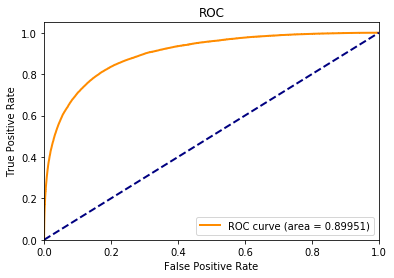

In [36]:
fpr, tpr, threshold = roc_curve(target, oof)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.5f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel("False Positive Rate")  
plt.ylabel("True Positive Rate")  
plt.title("ROC")  
plt.legend(loc="lower right")
plt.show()

### 7、画出特征重要性

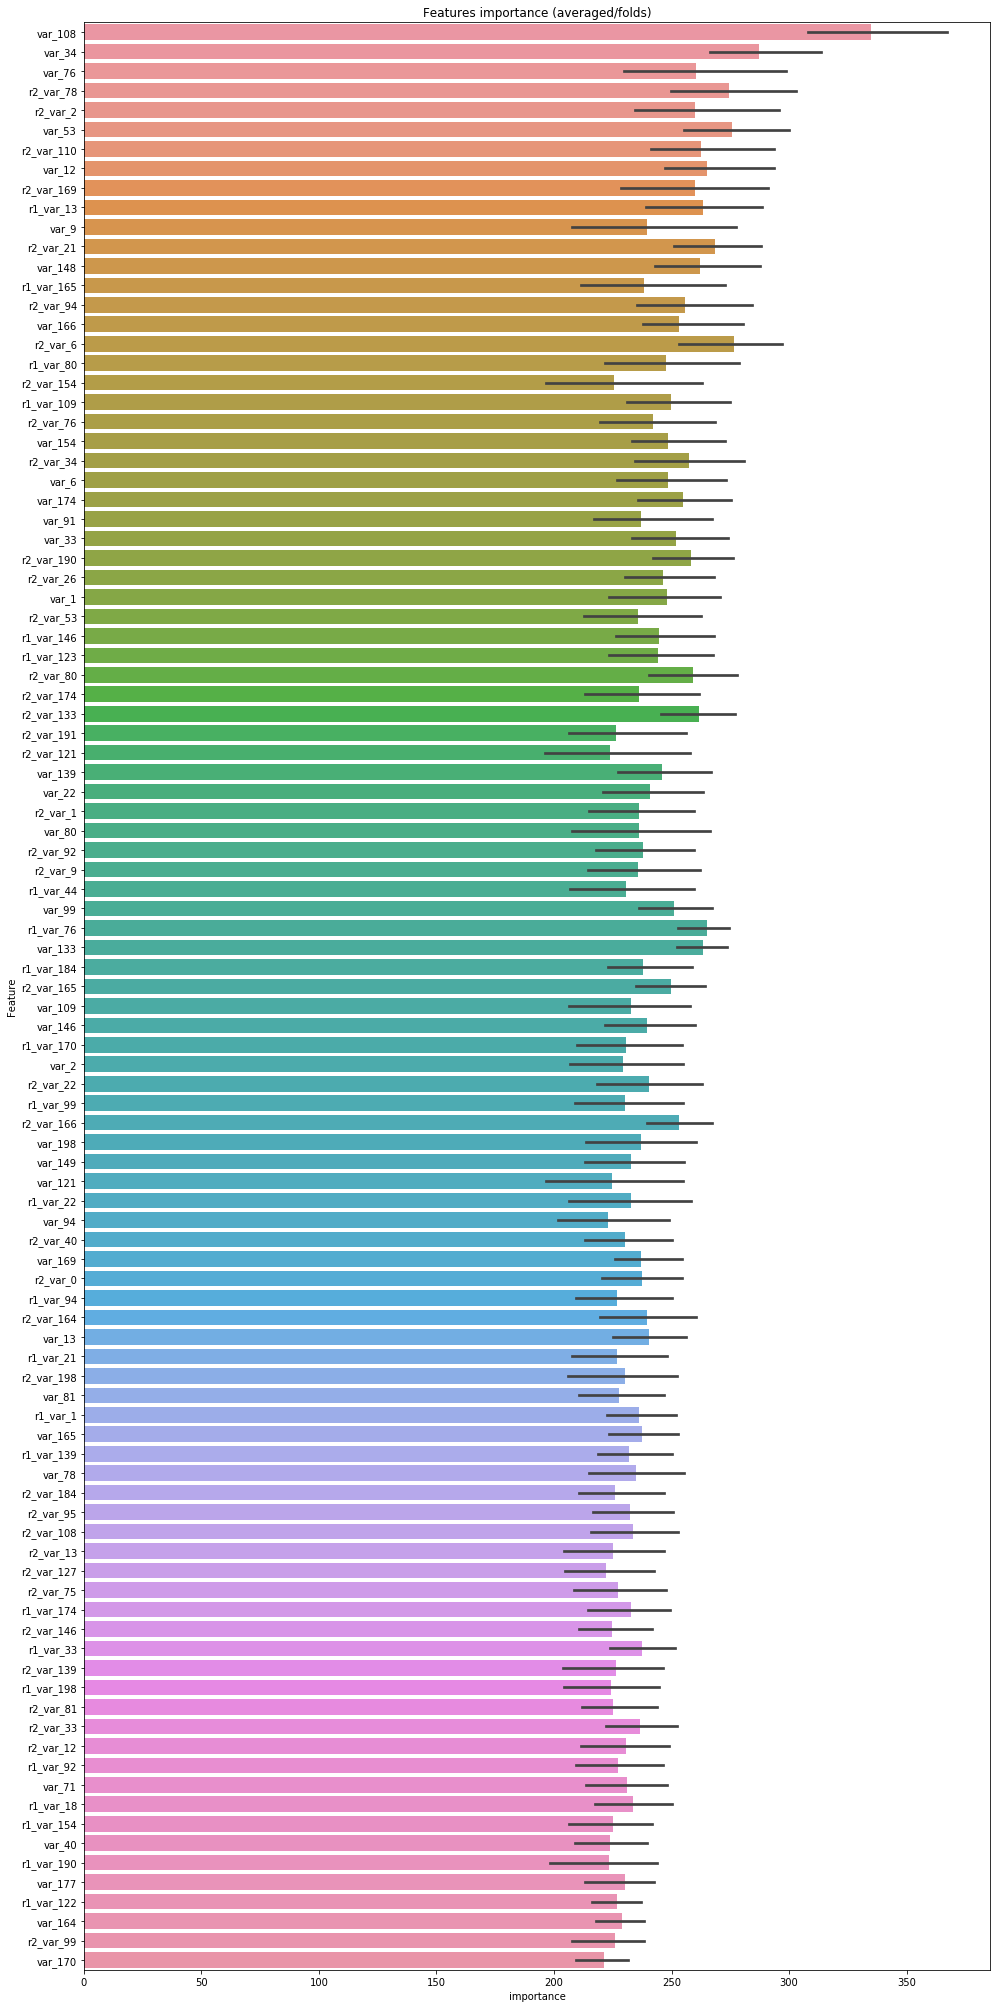

In [41]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig("./result/feat_import.png")

### 8、输出预测结果

In [42]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("./result/submission.csv", index=False)